In [21]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [4]:
# 試験ID生成
trial_prefix = 'nb006'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb006
nb006_20210522_183608


In [5]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [7]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [8]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [9]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [10]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [11]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [12]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## テキスト特徴_W2V

In [14]:
text_normalization(train_base['excerpt']).\
                            map(lambda x: [i for i in x.split(' ') if i not in (' ')])

0       [young, people, returned, ballroom, presented,...
1       [dinner, time, mrs, fayre, somewhat, silent, e...
2       [roger, predicted, snow, departed, quickly, ca...
3       [outside, palace, great, garden, walled, round...
4       [upon, time, three, bears, lived, together, ho...
                              ...                        
2829    [think, dinosaurs, lived, picture, see, hot, s...
2830    [solid, solids, usually, hard, molecules, pack...
2831    [second, state, matter, discuss, liquid, solid...
2832    [solids, shapes, actually, touch, three, dimen...
2833    [animals, made, many, cells, eat, things, dige...
Name: excerpt, Length: 2834, dtype: object

In [23]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      iter=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"{self.column}_w2v_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


In [24]:
block = W2VTrainBlock('excerpt')
block.fit(train_base).head()

100%|██████████| 2834/2834 [00:00<00:00, 5243.97it/s]


,excerpt_w2v_w5_0,excerpt_w2v_w5_1,excerpt_w2v_w5_2,excerpt_w2v_w5_3,excerpt_w2v_w5_4,excerpt_w2v_w5_5,excerpt_w2v_w5_6,excerpt_w2v_w5_7,excerpt_w2v_w5_8,excerpt_w2v_w5_9,...,excerpt_w2v_w5_40,excerpt_w2v_w5_41,excerpt_w2v_w5_42,excerpt_w2v_w5_43,excerpt_w2v_w5_44,excerpt_w2v_w5_45,excerpt_w2v_w5_46,excerpt_w2v_w5_47,excerpt_w2v_w5_48,excerpt_w2v_w5_49
0,-0.309913,0.477503,0.309229,0.171999,0.556344,0.137015,-0.602427,0.859304,-0.626054,-0.349846,...,0.023053,0.505093,0.207757,0.434700,-0.000794,-0.206733,-0.091480,-0.377382,0.108836,-0.294625
1,-0.551568,0.440694,-0.112454,-0.343997,-0.311091,-0.147394,0.342608,0.379102,-0.129853,0.914005,...,0.787819,0.569010,-0.088584,0.574648,0.192054,-0.110191,0.048589,-0.872392,0.200226,-0.511015
2,-1.138851,-0.374274,0.748325,0.140391,-0.682606,0.017294,0.139552,0.522715,0.089880,0.110367,...,0.459682,0.754606,-0.032553,1.031580,0.000153,-0.432734,0.049942,-0.652425,0.004438,-0.941233
3,-0.688999,0.221265,0.286058,-0.394982,0.184925,0.052345,-0.089314,0.873173,-0.966157,-0.155678,...,0.688325,0.962675,-1.069379,-0.005000,-0.419760,0.302285,-0.541703,-0.737626,0.406230,-1.483567
4,-0.810909,0.836584,1.137584,-0.077933,-0.796897,1.234124,0.329052,1.966863,-1.486659,0.672583,...,0.146408,1.093466,1.201603,1.471446,-1.123078,-1.093249,-0.771306,-0.196122,-0.437443,-2.431511


In [26]:
block = W2VTrainBlock('excerpt',
                      model_size=30,
                      min_count=1,
                      window=10,
                      n_iter=200)
block.fit(train_base).head()

100%|██████████| 2834/2834 [00:00<00:00, 4639.28it/s]


,excerpt_w2v_w10_0,excerpt_w2v_w10_1,excerpt_w2v_w10_2,excerpt_w2v_w10_3,excerpt_w2v_w10_4,excerpt_w2v_w10_5,excerpt_w2v_w10_6,excerpt_w2v_w10_7,excerpt_w2v_w10_8,excerpt_w2v_w10_9,...,excerpt_w2v_w10_20,excerpt_w2v_w10_21,excerpt_w2v_w10_22,excerpt_w2v_w10_23,excerpt_w2v_w10_24,excerpt_w2v_w10_25,excerpt_w2v_w10_26,excerpt_w2v_w10_27,excerpt_w2v_w10_28,excerpt_w2v_w10_29
0,-0.414121,1.099451,0.376720,0.650569,1.107706,-0.898256,-1.631123,-0.152786,-0.165364,-0.069962,...,-0.337220,0.179148,-0.259326,-1.838944,-0.871585,0.626948,-0.811941,1.309527,-0.799713,-0.548959
1,-0.967560,1.286708,-0.419474,0.644824,-1.405448,-1.451139,0.785319,-0.944330,-0.068552,1.407340,...,1.060010,-1.749103,0.835414,-0.442207,-0.452272,0.890647,0.854728,1.340581,-0.766925,-0.626203
2,-1.176579,-0.042418,0.788666,0.547027,-0.095499,-1.437113,-0.254824,-0.081275,0.974774,0.614979,...,0.810425,-0.219027,0.546527,-0.098314,-0.714051,0.845485,0.328761,1.022893,-0.027014,-0.662012
3,0.134159,0.245120,0.684838,-0.851445,1.333058,-0.624114,0.310908,0.651914,-1.455788,0.374762,...,0.789451,-0.014834,0.238405,-2.291021,-0.933756,1.179616,-0.312404,1.231890,0.598173,-1.758664
4,-0.396743,1.626226,2.850019,0.699138,1.120703,-1.207624,0.208727,1.511964,-1.475596,0.892320,...,0.409512,-0.381758,-1.303010,-1.496099,-1.443279,2.411515,0.829097,2.946901,-0.743626,-0.126724


## 可視化

In [27]:
from MulticoreTSNE import MulticoreTSNE as TSNE
def tsne_run_and_show(z):
    tsne = TSNE(n_jobs=-1)
    embedding = tsne.fit_transform(z)

    bin_labels = pd.cut(train_base['target'], bins=5)
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(*embedding.T, c=bin_labels.cat.codes, s=20, alpha=.8, cmap='cividis')
    ax.grid()

100%|██████████| 2834/2834 [00:00<00:00, 5115.97it/s]


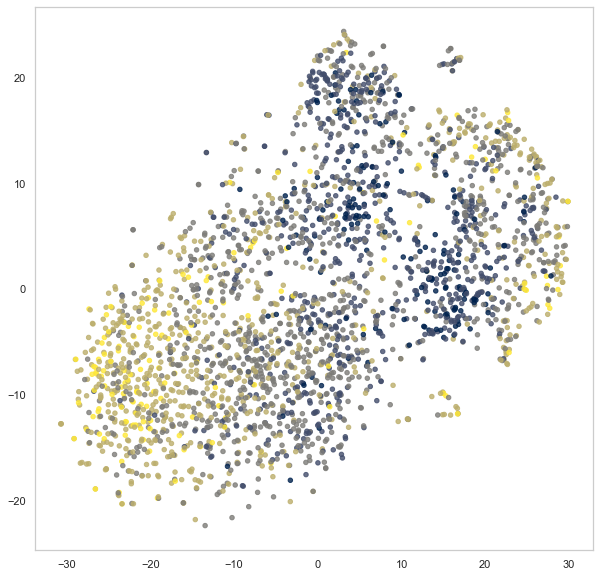

In [35]:
block = W2VTrainBlock('excerpt', window=1)
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

100%|██████████| 2834/2834 [00:00<00:00, 5132.45it/s]


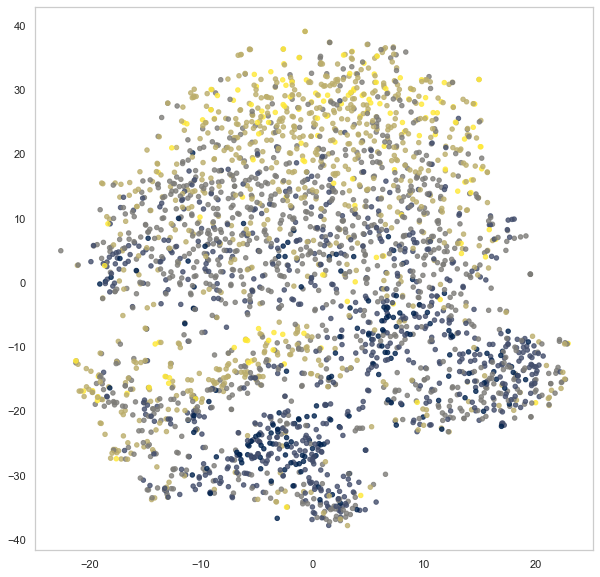

In [33]:
block = W2VTrainBlock('excerpt', window=3)
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

100%|██████████| 2834/2834 [00:00<00:00, 4711.14it/s]


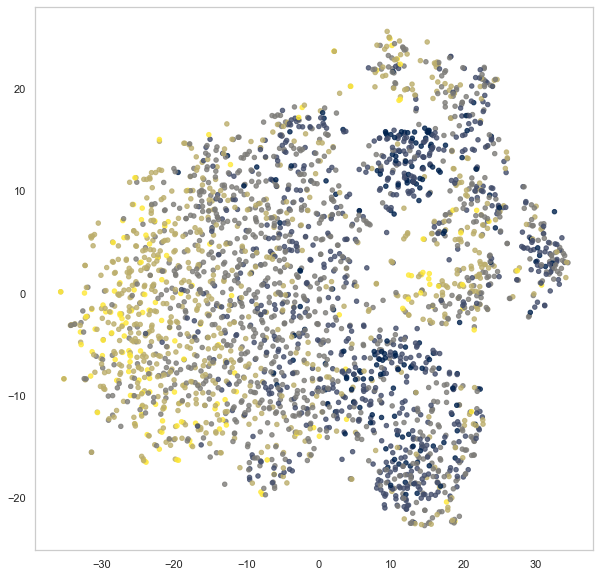

In [28]:
block = W2VTrainBlock('excerpt')
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

100%|██████████| 2834/2834 [00:00<00:00, 5098.20it/s]


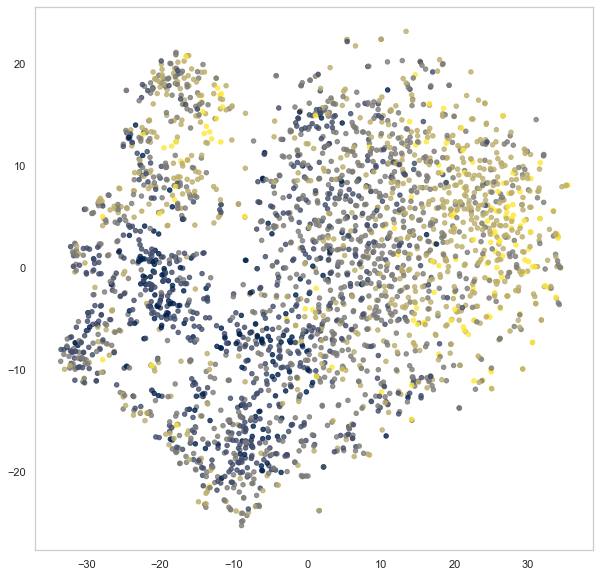

In [34]:
block = W2VTrainBlock('excerpt', window=10)
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

100%|██████████| 2834/2834 [00:00<00:00, 5081.88it/s]


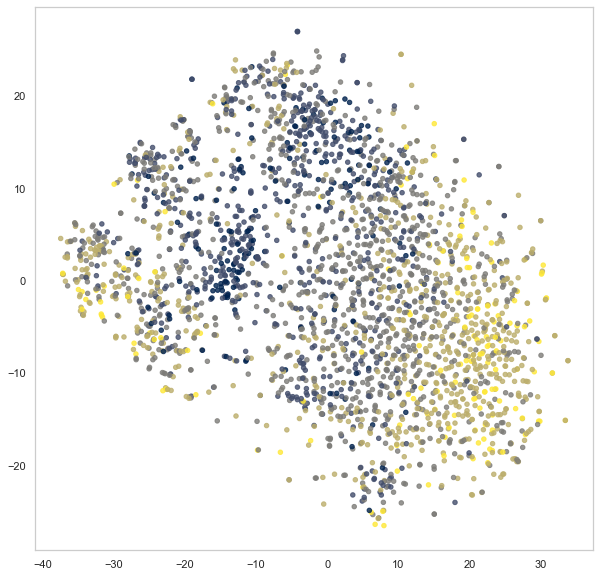

In [29]:
block = W2VTrainBlock('excerpt', window=50)
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

100%|██████████| 2834/2834 [00:00<00:00, 4346.83it/s]


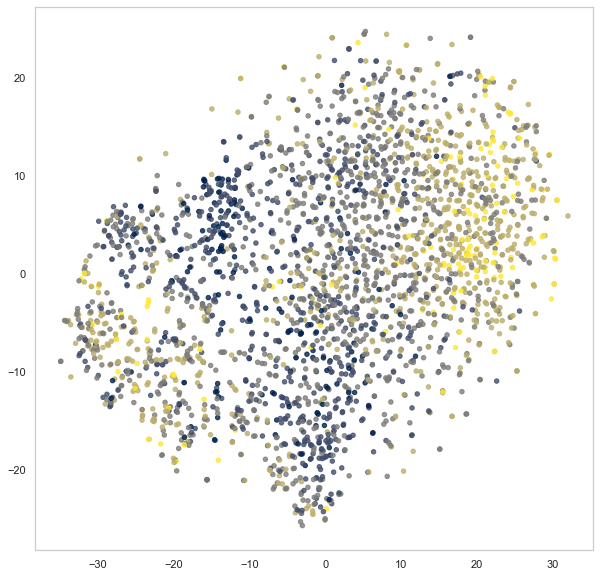

In [30]:
block = W2VTrainBlock('excerpt', window=100)
z = block.fit(train_base, train_base)
tsne_run_and_show(z)

- window_sizeを変えても、パリッとした傾向差は見られない。
- 3,10,100で様子見るか。

# make_feat

In [56]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')
#whole_df = train_base.copy()

In [57]:
# block初期化
w2v_w3 = W2VTrainBlock('excerpt', window=3)
w2v_w10 = W2VTrainBlock('excerpt', window=10)
w2v_w100 = W2VTrainBlock('excerpt', window=100)

In [58]:
# fit & trainの特徴作成

# 対象dfとは別に、特徴作成用dfを指定するもの
train_feat = pd.concat([train_feat, w2v_w3.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w10.fit(train_base, whole_df)], axis='columns')
train_feat = pd.concat([train_feat, w2v_w100.fit(train_base, whole_df)], axis='columns')

100%|██████████| 2834/2834 [00:00<00:00, 4176.12it/s]


In [59]:
# testの特徴作成

# 対象dfとは別に、特徴作成用dfを指定するもの
test_feat = pd.concat([test_feat, w2v_w3.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w10.transform(test_base)], axis='columns')
test_feat = pd.concat([test_feat, w2v_w100.transform(test_base)], axis='columns')

100%|██████████| 7/7 [00:00<00:00, 1536.70it/s]


In [60]:
print(train_feat.shape)
train_feat.head()

(2834, 150)


,excerpt_w2v_w3_0,excerpt_w2v_w3_1,excerpt_w2v_w3_2,excerpt_w2v_w3_3,excerpt_w2v_w3_4,excerpt_w2v_w3_5,excerpt_w2v_w3_6,excerpt_w2v_w3_7,excerpt_w2v_w3_8,excerpt_w2v_w3_9,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,-0.640120,0.273554,0.199980,-0.060991,0.220643,0.210120,-0.140930,0.579749,-0.761407,-0.271971,...,-0.308530,-0.619390,-0.086123,1.350753,-0.427655,-0.385517,1.339031,0.075111,0.369039,-1.382579
1,-0.907909,0.225035,-0.114038,-0.407738,-0.653281,-0.210361,0.693874,0.410698,-0.213477,0.486991,...,0.136349,-0.118249,-0.405949,1.217798,0.749327,1.687408,1.511721,-1.886704,-1.652155,-0.004721
2,-1.169739,-0.074897,0.376102,0.166048,-0.577251,-0.019999,0.431483,0.482049,-0.076077,-0.211287,...,-0.148583,1.848912,-0.749896,1.230469,1.197842,1.486613,1.735148,-3.217331,-0.318002,-0.681664
3,-0.978373,0.156640,0.381602,-0.729215,-0.160951,-0.021152,0.021110,0.911211,-0.769252,-0.288272,...,0.997194,2.627172,-3.251379,1.271348,-0.205094,0.715266,0.181919,0.019190,0.562984,-2.211291
4,-1.403516,0.406560,1.411866,-0.773988,-0.895908,0.804016,0.818198,0.362847,-1.215289,0.087092,...,1.964275,1.954252,0.191191,-1.859735,0.627330,-0.748705,2.278416,-1.681606,-0.534895,-3.466207


In [61]:
print(test_feat.shape)
test_feat.head()

(7, 150)


,excerpt_w2v_w3_0,excerpt_w2v_w3_1,excerpt_w2v_w3_2,excerpt_w2v_w3_3,excerpt_w2v_w3_4,excerpt_w2v_w3_5,excerpt_w2v_w3_6,excerpt_w2v_w3_7,excerpt_w2v_w3_8,excerpt_w2v_w3_9,...,excerpt_w2v_w100_40,excerpt_w2v_w100_41,excerpt_w2v_w100_42,excerpt_w2v_w100_43,excerpt_w2v_w100_44,excerpt_w2v_w100_45,excerpt_w2v_w100_46,excerpt_w2v_w100_47,excerpt_w2v_w100_48,excerpt_w2v_w100_49
0,-1.289571,-0.105486,0.565125,0.120643,-0.325863,0.120699,0.261559,0.796486,-0.117501,-0.757903,...,1.105780,-0.980383,-0.263888,-2.331045,-0.680072,0.046876,0.385608,-3.566005,-0.180487,0.074548
1,-1.093920,0.342445,0.294792,-0.321853,-0.692706,-0.203020,0.494117,0.228921,0.017563,-0.140440,...,2.096936,-0.099768,-0.497704,1.318463,0.033076,-0.289868,0.823263,-0.802460,-1.169264,0.104580
2,-1.142412,0.330289,-0.312631,-0.421675,-0.469234,-0.200027,0.235593,0.752003,-0.427425,0.459502,...,-0.932850,0.160907,-2.121637,0.294715,1.115665,0.335264,2.094563,-0.478512,1.201314,-2.151174
3,-0.959792,0.306470,-0.314225,0.419410,0.090890,1.117022,0.103180,0.772128,-0.656147,-0.476615,...,-2.222425,-0.090011,-0.887493,0.938224,-3.172751,1.942781,5.548974,-1.694267,2.994113,0.039109
4,-0.163492,-0.101929,-0.633775,0.069213,0.481106,0.448645,0.104164,0.115762,-0.324282,-0.351660,...,-0.968166,0.191039,0.519269,-1.298152,-1.145937,0.206258,0.734093,-0.134818,-1.061345,-0.868709


# train & predict

In [62]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [63]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [64]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [65]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [66]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 150
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.342052	valid's rmse: 0.71118
Early stopping, best iteration is:
[34]	training's rmse: 0.42781	valid's rmse: 0.707832

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 150
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.342

In [67]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [68]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-1.333009
1,f0953f0a5,-0.452241
2,0df072751,-0.685377
3,04caf4e0c,-1.487961
4,0e63f8bea,-1.666742


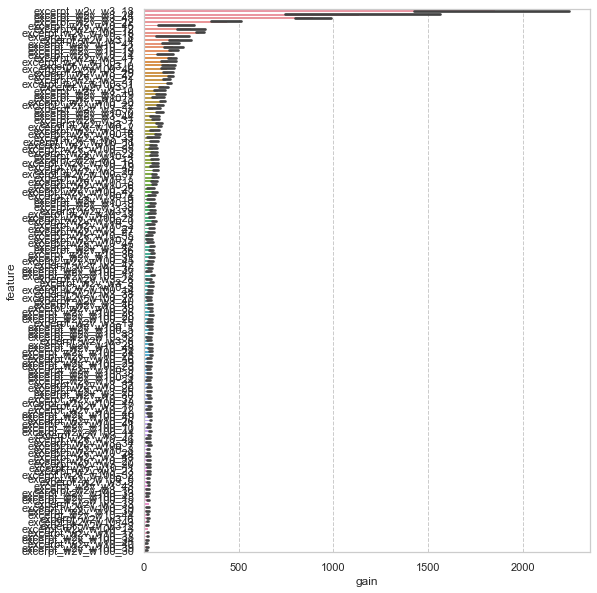

In [69]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

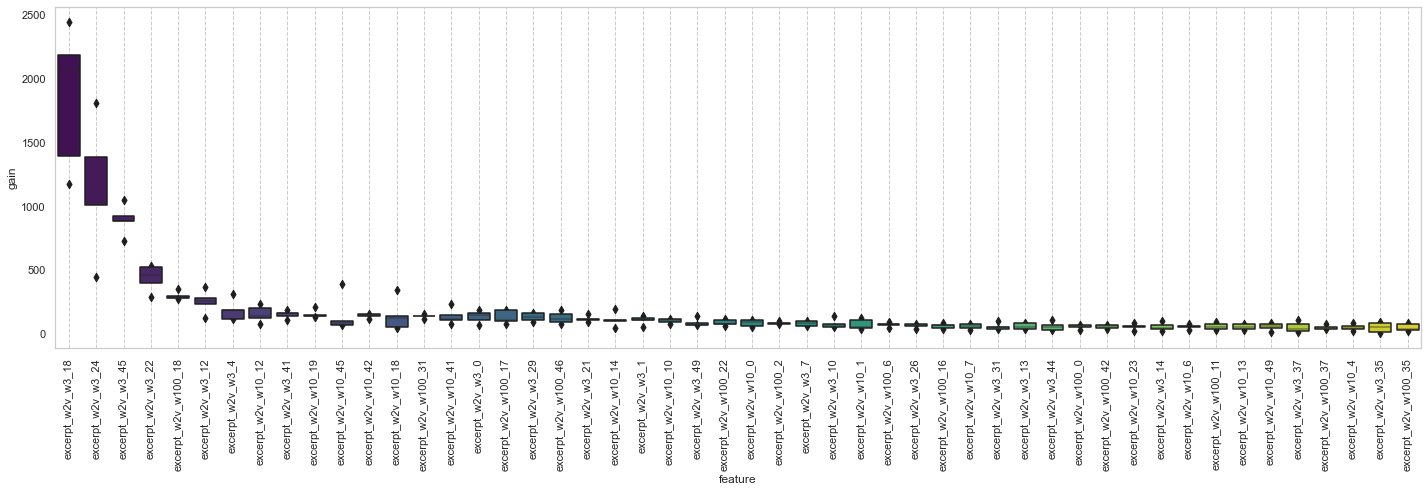

In [70]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [71]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

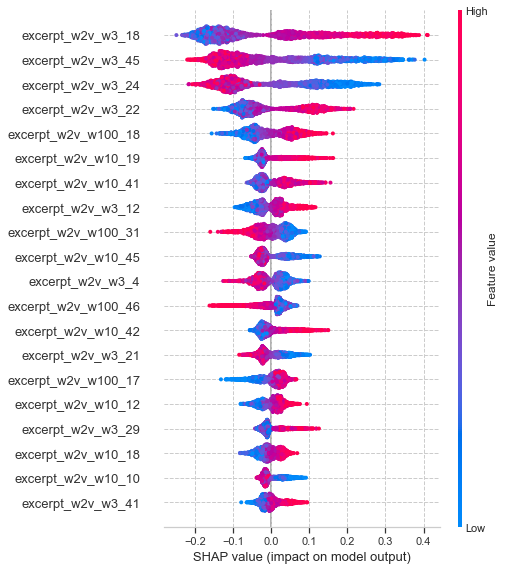

In [72]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

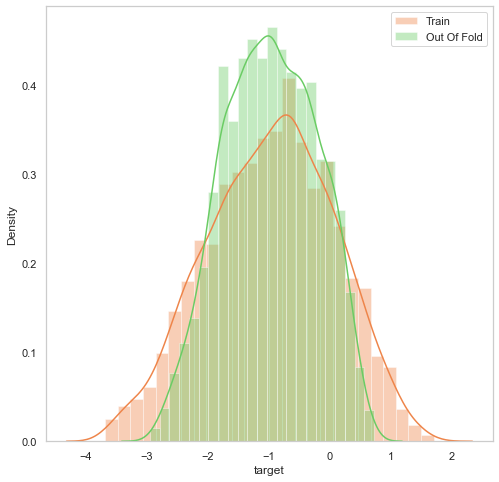

In [73]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))